_Neural Data Science_

Lecturer: Dr. Jan Lause, Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Fabio Seel, Julius Würzler

Summer term 2025


Student names: <span style='background: yellow'>Aakarsh Nair, Andreas Kotzur, Ahmed Eldably</span>

LLM Disclaimer: <span style='background: yellow'>*Did you use an LLM to solve this exercise? If yes, which one and where did you use it? Chat GPT 4o, Google Gemini  - Task Tracking, Template Code, Background Knowledge, Plotting </span>

# Coding Lab 5

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as opt
import scipy.io as io

%load_ext jupyter_black

%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p sklearn

%matplotlib inline
plt.style.use("../matplotlib_style.txt")

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: 2025-05-25 13:32:33CEST

Python implementation: CPython
Python version       : 3.11.11
IPython version      : 9.2.0

sklearn: 1.6.1

sklearn   : 1.6.1
scipy     : 1.15.2
matplotlib: 3.9.4
pyglmnet  : 1.1
numpy     : 1.26.4

Watermark: 2.5.0



# Task 1: Fit RF on simulated data

We will start  with toy data generated from an LNP model neuron to make sure everything works right. The model LNP neuron consists of one Gaussian linear filter, an exponential nonlinearity and a Poisson spike count generator. We look at it in discrete time with time bins of width $\delta t$. The model is:

$$
c_t \sim Poisson(r_t)\\
r_t = \exp(w^T s_t) \cdot \Delta t \cdot R
$$

Here, $c_t$ is the spike count in time window $t$ of length $\Delta t$, $s_t$ is the stimulus and $w$ is the receptive field of the neuron. The receptive field variable `w` is 15 × 15 pixels and normalized to $||w||=1$. A stimulus frame is a 15 × 15 pixel image, for which we use uncorrelated checkerboard noise (binary) with a stimulus intesity of 5 (peak to peak). R can be used to bring the firing rate into the right regime (e.g. by setting $R=50$).      

For computational ease, we reformat the stimulus and the receptive field in a 225 by 1 array. The function ```sample_lnp``` can be used to generate data from this model. It returns a spike count vector `c` with samples from the model (dimensions: 1 by nT = $T/\Delta t$), a stimulus matrix `s` (dimensions: 225 × nT) and the mean firing rate `r` (dimensions: nT × 1). 

Here we assume that the receptive field influences the spike count instantaneously just as in the above equations. Implement a Maximum Likelihood approach to fit the receptive field. 

To this end derive mathematically and implement the log-likelihood function $L(w)$ and its gradient $\frac{L(w)}{dw}$ with respect to $w$ (`negloglike_lnp`). The log-likelihood of the model is
$$L(w) = \log \prod_t \frac{r_t^{c_t}}{c_t!}\exp(-r_t).$$

Make sure you include intermediate steps of the mathematical derivation in your answer, and you give as final form the maximally simplified expression, substituting the corresponding variables.

Plot the stimulus for one frame, the cell's response over time and the spike count vs firing rate. Plot the true and the estimated receptive field. 

*Grading: 2 pts (calculations) + 4 pts (generation) + 4 pts (implementation)*


### Calculations (2 pts)
_You can add your calculations in_ $\LaTeX$ _here_. 

$$
\begin{align}
L(\omega) &= \sum_t \log \left[ \frac{r_t^{c_t}}{c_t!} \exp(-r_t) \right] \\
          &= \sum_t \log \left[ (r_t)^{c_t} \exp(-r_t)   -\log(c_t!) \right]\\
          &= \sum_t c_t \log(r_t) + \log(\exp(-r_t))  -\log(c_t!)\\
          &= \sum_t c_t \log(\exp(w^Ts_t)) -r_t - \log(c_t!) + c_t \log(\Delta t \cdot R) \\
          &= \sum_t c_t (w^T s_t) - r_t - \log(c_t!) + c_t \log(\Delta t \cdot R) \\
          &= \sum_t c_t w^Ts_t - \exp(w^T s_t) \Delta \cdot R - \log(c_t!) + c_t \log (\Delta t \cdot R)
\end{align}
$$

$$
\begin{align}
\frac{d L(\omega)}{d\omega} &= D_w \left[  \sum_t c_t w^T s_t  - \exp(w^T, s_t) \Delta t \cdot R  - \log(c_t!) + c_t \log(\Delta t \cdot R) \right] \\
&=  \left[  \sum_t D_w \left(c_t w^T s_t  - \exp(w^T s_t) \Delta t \cdot R  - \log(c_t!) + c_t \log(\Delta t \cdot R)  \right) \right] \\ 
&= \left[ \sum_t c_t s_t  - \exp(w^T s_t) s_t \Delta t \cdot R + 0 + 0 + 0 \right] \\ 
&= \left[ \sum_t c_t s_t -\exp(w^T s_t) s_t \Delta t \cdot R \right] \\ 
&= \sum_t (s_t (c_t - r_t)) 
\end{align}
$$

### Generate data (2 pts)

Text(0.5, 1.0, 'Gaussian RF')

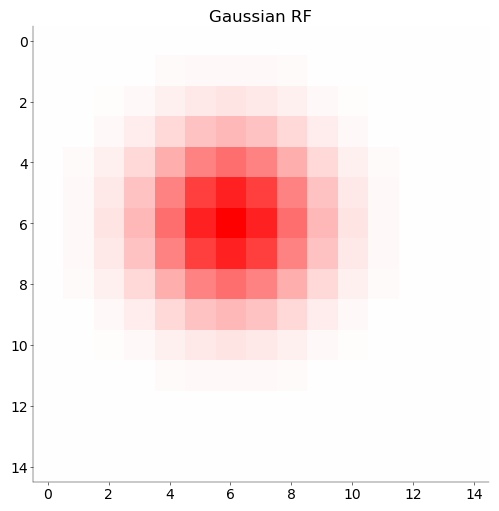

In [37]:
def gen_gauss_rf(D: int, width: float, center: tuple = (0, 0)) -> np.ndarray:
    """
    Generate a Gaussian receptive field.

    Args:
        D (int): Size of the receptive field (DxD).
        width (float): Width parameter of the Gaussian.
        center (tuple, optional): Center coordinates of the receptive field. Defaults to (0, 0).

    Returns:
        np.ndarray: Gaussian receptive field.
    """

    sz = (D - 1) / 2
    x, y = np.meshgrid(np.arange(-sz, sz + 1), np.arange(-sz, sz + 1))
    x = x + center[0]
    y = y + center[1]
    w = np.exp(-(x**2 / width + y**2 / width))
    w = w / np.sum(w.flatten())

    return w


w = gen_gauss_rf(15, 7, (1, 1))

vlim = np.max(np.abs(w))
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(w, cmap="bwr", vmin=-vlim, vmax=vlim)
ax.set_title("Gaussian RF")

In [38]:
# %% Calculate the firing rate for each frame
def calculate_firing_rate(
    stim_frame: np.ndarray, w: np.ndarray, dt: float, R: float
) -> float:
    """
    Calculates the instantaneous firing rate r_t for an LNP neuron.

    Args:
        stim_frame (np.ndarray): The current flattened stimulus frame.
        w (np.ndarray): The flattened receptive field kernel.
        dt (float): Duration of a frame in s.
        R (float): Rate parameter.

    Returns:
        float: The calculated mean firing rate r_t.
    """
    # Linear Filtering (w^T s_t)
    linear_response = np.dot(w, stim_frame)

    # Non-linearity and Rate Calculation
    # r_t = exp(w^T s_t) * dt * R
    rate_t = np.exp(linear_response) * dt * R

    return rate_t

In [39]:
# %% Create the stimulus matrix
def generate_all_stimulus_frames(
    num_pixels: int, nT: int, s_i: float, rng: np.random.Generator
) -> np.ndarray:
    """
    Generates all stimulus frames in one shot.

    Args:
        num_pixels (int): The total number of pixels in the flattened frame.
        nT (int): The number of time steps (frames).
        s_i (float): The peak-to-peak intensity of the stimulus.
        rng (np.random.Generator): A NumPy random number generator instance.

    Returns:
        np.ndarray: A 2D array of shape (num_pixels, nT) representing all stimulus frames.
    """
    # Generate random binary values (-1 or 1) for all pixels and all time steps
    random_binary_patterns = rng.choice([-1, 1], size=(num_pixels, nT))

    # Scale to achieve the desired peak-to-peak intensity
    s_all = random_binary_patterns * (s_i / 2.0)

    return s_all

In [40]:
def sample_lnp(
    w: np.array, nT: int, dt: float, R: float, s_i: float, random_seed: int = 10
):
    """Generate samples from an instantaneous LNP model neuron with
    receptive field kernel w.

    Parameters
    ----------

    w: np.array, (Dx * Dy, )
        (flattened) receptive field kernel.

    nT: int
        number of time steps

    dt: float
        duration of a frame in s

    R: float
        rate parameter

    s_i: float
        stimulus intensity peak to peak

    random_seed: int
        seed for random number generator

    Returns
    -------

    c: np.array, (nT, )
        sampled spike counts in time bins

    r: np.array, (nT, )
        mean rate in time bins

    s: np.array, (Dx * Dy, nT)
        stimulus frames used

    Note
    ----

    See equations in task description above for a precise definition
    of the individual parameters.

    """

    rng = np.random.default_rng(random_seed)

    # ------------------------------------------------
    # Generate samples from an instantaneous LNP model
    # neuron with receptive field kernel w. (1 pt)
    # ------------------------------------------------

    # Store all the stimulus frames in a 2D array
    s_all = generate_all_stimulus_frames(w.shape[0], nT, s_i, rng)

    # Store the mean rate in a 1D array
    r_all = np.zeros(nT)

    # Store the sampled spike counts in a 1D array
    # (spike counts in time bins)
    c_all = np.zeros(nT)

    for t in range(nT):
        r_all[t] = calculate_firing_rate(s_all[:, t], w, dt, R)
        c_all[t] = rng.poisson(r_all[t])

    return c_all, r_all, s_all

In [41]:
D = 15  # number of pixels
nT = 1000  # number of time bins
dt = 0.1  # bins of 100 ms
R = 50  # firing rate in Hz
s_i = 5  # stimulus intensity

w = gen_gauss_rf(D, 7, (1, 1))
w = w.flatten()

c, r, s = sample_lnp(w, nT, dt, R, s_i)

Plot the stimulus for one frame, the cell's response over time and the spike count vs firing rate.

In [42]:
def plot_spike_count_vs_firing_rate(r, c, ax):
    """
    Plot spike count vs firing rate.

    Args:
        r (np.ndarray): Mean firing rate.
        c (np.ndarray): Spike counts.
        ax (matplotlib.axes.Axes): Axes to plot on.
    """
    ax.scatter(r, c, alpha=0.5, s=10)  # s is marker size
    ax.set_xlabel("Mean Firing Rate $r_t$")
    ax.set_ylabel("Spike Count $c_t$")
    ax.set_title("Spike Count vs. Firing Rate")


def plot_cell_response_over_time(r, c, dt, ax):
    """
    Plot cell's response over time.

    Args:
        r (np.ndarray): Mean firing rate.
        c (np.ndarray): Spike counts.
        dt (float): Duration of a frame in seconds.
        ax (matplotlib.axes.Axes): Axes to plot on.
    """
    time_axis = np.arange(len(r)) * dt
    ax.plot(time_axis, r, label="Mean Firing Rate $r_t$")
    ax.stem(
        time_axis,
        c,
        linefmt="grey",
        markerfmt=".",
        basefmt=" ",
        label="Spike Counts $c_t$",
    )  # use_line_collection for newer matplotlib
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Rate / Spikes")
    ax.set_title("Cell's Response Over Time")
    ax.legend()


def plot_stimulus_frame(stim_frame, D, ax):
    """
    Plot a stimulus frame.
    Args:
        stim_frame (np.ndarray): Flattened stimulus frame.
        D (int): Side dimension of the square stimulus image.
        ax (matplotlib.axes.Axes): Axes to plot on.
    """
    # Reshape it back to 2D (assuming it was a DxD image, e.g., 15x15)
    stim_frame_2d = stim_frame.reshape((D, D))
    # Plot using imshow
    im = ax.imshow(
        stim_frame_2d, cmap="gray"
    )  # 'gray' or 'binary' colormap often used for checkerboards
    ax.set_title(f"Stimulus Frame ({D}x{D})")
    ax.set_xticks([])  # Optional: remove x-axis ticks
    ax.set_yticks([])  # Optional: remove y-axis ticks


def plot_all(ax, stim_frame, r, c, dt, D, save_path=None):
    """
    Plot all components: stimulus frame, cell's response over time, and spike count vs firing rate.
    Args:
        ax (matplotlib.axes.Axes): Axes to plot on.
        stim_frame (np.ndarray): Flattened stimulus frame.
        r (np.ndarray): Mean firing rate.
        c (np.ndarray): Spike counts.
        dt (float): Duration of a frame in seconds.
        D (int): Side dimension of the square stimulus image.
    """
    plot_stimulus_frame(stim_frame, D, ax["stim"])
    plot_cell_response_over_time(r, c, dt, ax["responses"])
    plot_spike_count_vs_firing_rate(r, c, ax["count/rate"])
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)

/var/folders/_q/9l1zk1853mv45phss2fsffd00000gn/T/ipykernel_26672/2808032760.py:75: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


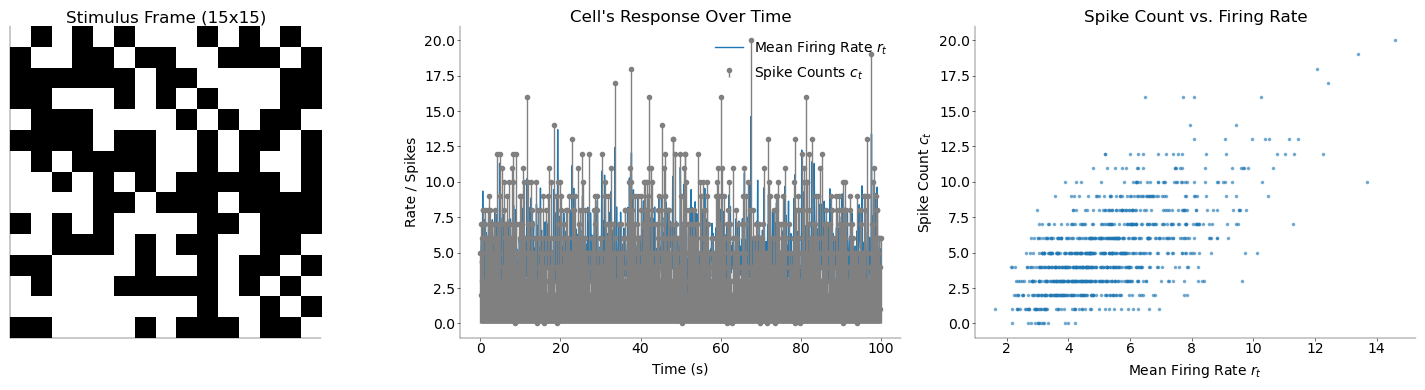

In [43]:
mosaic = mosaic = [["stim", "responses", "count/rate"]]

fig, ax = plt.subplot_mosaic(mosaic=mosaic, figsize=(15, 4))
# -----------------------------------------------------------------------------------------------------------
# Plot the stimulus for one frame, the cell's responses over time and spike count vs firing rate (1 pt)
# -----------------------------------------------------------------------------------------------------------

# Reshape it back to 2D (assuming it was a DxD image, e.g., 15x15)
# D should be the side dimension of your square stimulus image (e.g., 15)
# Make sure D*D matches stim_frame_to_plot_flat.shape[0]
stim_frame_to_plot_flat = s[:, 0]  # Get the first frame
stim_frame_2d = stim_frame_to_plot_flat.reshape((D, D))

plot_all(ax, stim_frame_2d, r, c, dt, D, save_path="../images/stimulus_plot.png")
plt.show()

### Implementation (3 pts)

Implement the negative log-likelihood of the LNP and its gradient with respect to the receptive field using the simplified equations you calculated earlier _(1 pt)_

In [44]:
def negloglike_lnp(
    w: np.array, c: np.array, s: np.array, dt: float = 0.1, R: float = 50
) -> float:
    """Implements the negative (!) log-likelihood of the LNP model

    Parameters
    ----------

    w: np.array, (Dx * Dy, )
      current receptive field

    c: np.array, (nT, )
      spike counts

    s: np.array, (Dx * Dy, nT)
      stimulus matrix


    Returns
    -------

    f: float
      function value of the negative log likelihood at w

    """

    # ------------------------------------------------
    # Implement the negative log-likelihood of the LNP
    # ------------------------------------------------
    # We derived
    # L(w) = \sum_t c_t w^Ts_t - \exp(w^T s_t) \Delta t \cdot R - \log(c_t!) + c_t \log(\Delta t \cdot R)
    w = w.flatten()
    g = np.dot(w.T, s)  # or w @ s
    rates = np.exp(g) * dt * R

    term1 = np.sum(c * g)
    term2 = np.sum(rates)
    import scipy.special

    # log(c!) can be computed using gammaln, we use it because it is numerically more stable than np.log(np.math.factorial(c))
    term3 = np.sum(scipy.special.gammaln(c + 1))
    if dt * R <= 0:
        return np.inf

    log_dt_R = np.log(dt * R)
    term4 = np.sum(c * log_dt_R)

    # Total log-likelihood L(w)
    log_likelihood = term1 - term2 - term3 + term4

    # Return the negative log-likelihood
    return -log_likelihood


def deriv_negloglike_lnp(
    w: np.array, c: np.array, s: np.array, dt: float = 0.1, R: float = 50
) -> np.array:
    """Implements the gradient of the negative log-likelihood of the LNP model

    Parameters
    ----------

    see negloglike_lnp

    Returns
    -------

    df: np.array, (Dx * Dy, )
      gradient of the negative log likelihood with respect to w

    """

    # --------------------------------------------------------------
    # Implement the gradient with respect to the receptive field `w`
    # --------------------------------------------------------------
    # Implement the formula:
    #       \frac{d -L(\omega)}{d\omega} = -\sum_t (s_t (c_t - r_t))
    w = w.flatten()
    g = np.dot(w.T, s)  # or w @ s
    rates = np.exp(g) * dt * R
    # This computes sum_t s_t * (c_t - r_t) and results in (num_pixels,)
    df = s @ (c - rates)
    return -df.flatten()

The helper function `check_grad` in `scipy.optimize` can help you to make sure your equations and implementations are correct. It might be helpful to validate the gradient before you run your optimizer.

In [45]:
# Check gradient
import scipy
import scipy.optimize

scipy.optimize.check_grad(
    lambda w: negloglike_lnp(w, c=c, s=s, dt=dt, R=R),
    lambda w: deriv_negloglike_lnp(w, c=c, s=s, dt=dt, R=R),
    np.zeros(225) * 0.001,  # Initial guess for w
)

0.003662109375

Fit receptive field maximizing the log likelihood.

The scipy.optimize package also has suitable functions for optimization. If you generate a large number of samples, the fitted receptive field will look more similar to the true receptive field. With more samples, the optimization takes longer, however.

In [ ]:
# ------------------------------------------
# Estimate the receptive field by maximizing
# the log-likelihood (or more commonly,
# minimizing the negative log-likelihood).
#
# Tips: use scipy.optimize.minimize(). (1 pt)
# ------------------------------------------

num_pixels = w.shape[0]  # Or D*D if w is not yet flattened here
initial_w_guess = np.random.rand(num_pixels) * 0.01  # Small random values
print(f"Starting optimization for {num_pixels} parameters...")
args_for_optimizer = (c, s, dt, R)

# 3. Call scipy.optimize.minimize
optimization_result = opt.minimize(
    fun=negloglike_lnp,  # The negative log-likelihood function
    x0=initial_w_guess,  # Initial guess for w
    args=args_for_optimizer,  # Additional arguments to fun and jac
    method="L-BFGS-B",  # A good quasi-Newton method that uses gradients
    jac=deriv_negloglike_lnp,  # The gradient of the negative log-likelihood
    options={
        "disp": True,
        "maxiter": 1000,
    },  # Display convergence messages & set max iterations
)

# 4. Extract the estimated receptive field
if optimization_result.success:
    w_estimated_task1 = optimization_result.x
    print("Optimization successful!")
    print(f"Final negative log-likelihood: {optimization_result.fun}")
else:
    w_estimated_task1 = optimization_result.x  # Still store it to see what happened
    print("Optimization FAILED.")
    print(f"Message: {optimization_result.message}")
    print(f"Current negative log-likelihood: {optimization_result.fun}")

Starting optimization for 225 parameters...
Optimization successful!
Final negative log-likelihood: 2077.354296869371


Plot the true and the estimated receptive field.

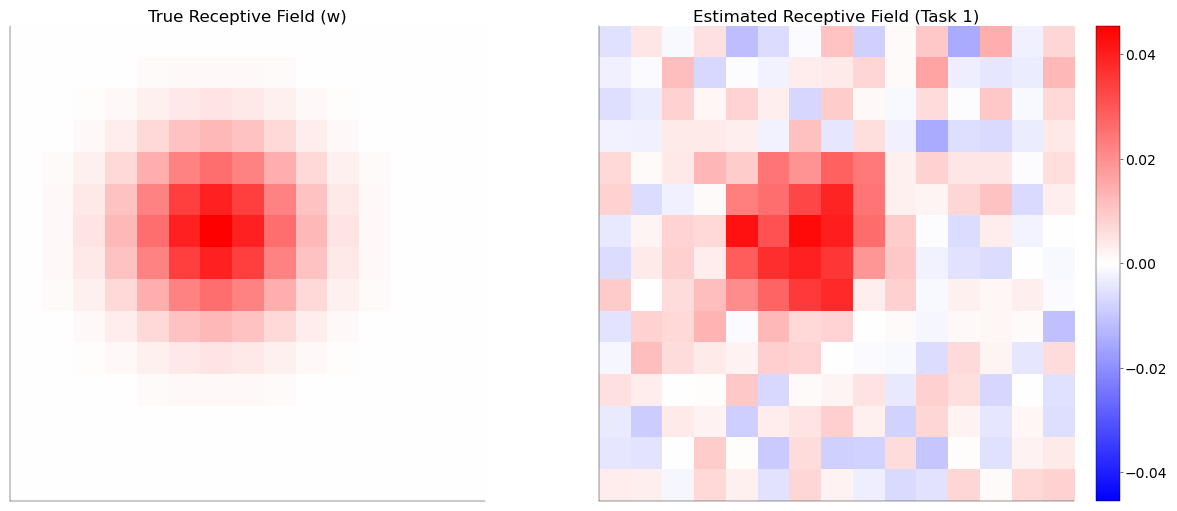

In [ ]:
# ------------------------------------
# Plot the ground truth and estimated
# `w` side by side. (1 pt)
# ------------------------------------
mosaic = [["True", "Estimated"]]
# INSTRUCTION: make sure to add a colorbar. 'bwr' is a reasonable choice for the cmap.

fig, ax = plt.subplot_mosaic(
    mosaic=mosaic, figsize=(12, 5), constrained_layout=True
)  # Added constrained_layout

# Reshape the flattened receptive fields back to 2D (DxD)
w_true_2d = w.reshape((D, D))
w_estimated_2d = w_estimated_task1.reshape((D, D))

# Determine a common color scale for fair comparison
# This makes sure that the same color value means the same RF strength in both plots
abs_max_true = np.max(np.abs(w_true_2d))
abs_max_est = np.max(np.abs(w_estimated_2d))
v_max_shared = max(
    abs_max_true, abs_max_est
)  # Use the larger of the two absolute maxima
v_min_shared = -v_max_shared

# Plot the true receptive field
im_true = ax["True"].imshow(w_true_2d, cmap="bwr", vmin=v_min_shared, vmax=v_max_shared)
ax["True"].set_title("True Receptive Field (w)")
ax["True"].set_xticks([])  # Optional: remove x-axis ticks
ax["True"].set_yticks([])  # Optional: remove y-axis ticks

# Plot the estimated receptive field
im_est = ax["Estimated"].imshow(
    w_estimated_2d, cmap="bwr", vmin=v_min_shared, vmax=v_max_shared
)
ax["Estimated"].set_title("Estimated Receptive Field (Task 1)")
ax["Estimated"].set_xticks([])
ax["Estimated"].set_yticks([])

fig.colorbar(
    im_est, ax=ax["Estimated"], orientation="vertical", fraction=0.046, pad=0.04
)

plt.show()

# Task 2: Apply to real neuron

Download the dataset for this task from Ilias (`nds_cl_5_data.mat`). It contains a stimulus matrix (`s`) in the same format you used before and the spike times. In addition, there is an array called `trigger` which contains the times at which the stimulus frames were swapped.

* Generate an array of spike counts at the same temporal resolution as the stimulus frames
* Fit the receptive field with time lags of 0 to 4 frames. Fit them one lag at a time (the ML fit is very sensitive to the number of parameters estimated and will not produce good results if you fit the full space-time receptive field for more than two time lags at once). 
* Plot the resulting filters

*Grading: 3.5 pts*


In [17]:
var = io.loadmat("../data/nds_cl_5_data.mat")

# t contains the spike times of the neuron
t = var["DN_spiketimes"].flatten()

# trigger contains the times at which the stimulus flipped
trigger = var["DN_triggertimes"].flatten()

# contains the stimulus movie with black and white pixels
s = var["DN_stim"]
s = s.reshape((300, 1500))  # the shape of each frame is (20, 15)
s = s[:, 1 : len(trigger)]

Create vector of spike counts

In [ ]:
# ------------------------------------------
# Bin the spike counts at the same temporal
# resolution as the stimulus (0.5 pts)
# ------------------------------------------
# spike_counts_per_frame.shape : (1488,)
num_frames = s.shape[1]  # Number of stimulus frames you are using
bin_edges = trigger[
    : num_frames + 1
]  # Use the first num_frames+1 trigger times as bin edges

spike_counts_per_frame, _ = np.histogram(t, bins=bin_edges)

Fit receptive field for each frame separately

In [22]:
delta = [0, 1, 2, 3, 4]  # List of lags to fit

In [23]:
def fit_rf_for_lag(
    lag_value: int,
    full_stimulus_matrix: np.ndarray,  # This is your s_real_data
    full_counts_vector: np.ndarray,  # This is your c_binned
    num_pixels: int,
    dt_param: float,
    R_param: float,
    initial_w_guess: np.ndarray = None,
    optimizer_method: str = "L-BFGS-B",
    deltas: list = [0, 1, 2, 3, 4],
) -> np.ndarray:
    """
    Fits a receptive field for a specific time lag.

    Args:
        lag_value (int): The time lag (e.g., 0, 1, 2, ...).
        full_stimulus_matrix (np.ndarray): The complete stimulus matrix (pixels, total_frames).
        full_counts_vector (np.ndarray): The complete binned spike counts (total_frames,).
        num_pixels (int): Number of pixels in the RF.
        dt_param (float): Time bin size delta_t.
        R_param (float): Rate parameter R.
        initial_w_guess (np.ndarray, optional): Initial guess for w. Defaults to small random.
        optimizer_method (str, optional): Optimization method for scipy.optimize.minimize.

    Returns:
        np.ndarray: The fitted receptive field for the given lag, or array of zeros if failed.
    """
    print(f"Attempting to fit receptive field for lag: {lag_value}...")

    if initial_w_guess is None:
        current_initial_w_guess = np.random.rand(num_pixels) * 0.01
    else:
        current_initial_w_guess = (
            initial_w_guess.copy()
        )  # Use a copy to avoid modification if it's passed around

    # --- Prepare lagged stimulus and corresponding spike counts ---
    if lag_value == 0:
        stimulus_for_fit = full_stimulus_matrix
        counts_for_fit = full_counts_vector
    else:
        if lag_value >= full_stimulus_matrix.shape[1] or lag_value >= len(
            full_counts_vector
        ):
            print(f"Lag value {lag_value} is too large for the data length. Skipping.")
            return np.zeros(num_pixels)  # Return zeros or raise error

        # Stimulus at t-lag_value predicts spikes at t
        stimulus_for_fit = full_stimulus_matrix[:, :-lag_value]
        counts_for_fit = full_counts_vector[lag_value:]

    # Ensure the number of time points match
    num_time_points_for_fit = len(counts_for_fit)
    # Adjust stimulus to match if it's longer (can happen if full_stimulus_matrix was longer than full_counts_vector initially)
    stimulus_for_fit = stimulus_for_fit[:, :num_time_points_for_fit]

    if stimulus_for_fit.shape[1] != len(counts_for_fit):
        print(
            f"Critical Error: Mismatch in time points for lag {lag_value} after adjustment: "
            f"Stimulus has {stimulus_for_fit.shape[1]} time points, "
            f"Counts have {len(counts_for_fit)} time points. Skipping fit."
        )
        return np.zeros(num_pixels)  # Or raise an error

    if stimulus_for_fit.shape[1] == 0:
        print(
            f"Skipping lag {lag_value} due to zero effective time points after lagging."
        )
        return np.zeros(num_pixels)

    # --- Perform the optimization ---
    try:
        optimization_result = scipy.optimize.minimize(
            negloglike_lnp,  # Your function from Task 1
            current_initial_w_guess,
            args=(counts_for_fit, stimulus_for_fit, dt_param, R_param),  # c, s, dt, R
            jac=deriv_negloglike_lnp,  # Your gradient function from Task 1
            method=optimizer_method,
            options={"maxiter": 500},  # Example: set max iterations
        )

        if optimization_result.success:
            fitted_w = optimization_result.x
            print(f"Successfully fitted RF for lag {lag_value}.")
            return fitted_w
        else:
            print(
                f"Optimization FAILED for lag {lag_value}: {optimization_result.message}"
            )
            return np.zeros(num_pixels)  # Or a more specific error indicator

    except Exception as e:
        print(f"An error occurred during optimization for lag {lag_value}: {e}")
        return np.zeros(num_pixels)


# fit for each delay
dt_real = np.median(np.diff(trigger))
w_hat = np.zeros((300, 5))  # Initialize the array to store the receptive fields
for i, lag in enumerate(delta):
    w_hat[:, i] = fit_rf_for_lag(
        lag_value=lag,
        full_stimulus_matrix=s,
        full_counts_vector=spike_counts_per_frame,
        num_pixels=300,  # 20 * 15 = 300
        dt_param=dt_real,  # 500 ms
        R_param=50,  # Rate parameter
        initial_w_guess=None,  # Use default small random guess
        optimizer_method="L-BFGS-B",  # Default method,
        deltas=delta,  # Pass the list of deltas
    )

Attempting to fit receptive field for lag: 0...
Successfully fitted RF for lag 0.
Attempting to fit receptive field for lag: 1...
Successfully fitted RF for lag 1.
Attempting to fit receptive field for lag: 2...
Successfully fitted RF for lag 2.
Attempting to fit receptive field for lag: 3...
Successfully fitted RF for lag 3.
Attempting to fit receptive field for lag: 4...
Successfully fitted RF for lag 4.


In [ ]:
# ------------------------------------------
# Fit the receptive field with time lags of
# 0 to 4 frames separately (1 pt)
#
# The final receptive field (`w_hat`) should
# be in the shape of (Dx * Dy, 5)
# ------------------------------------------

# specify the time lags
delta = [0, 1, 2, 3, 4]

Plot the frames one by one and explain what you see.

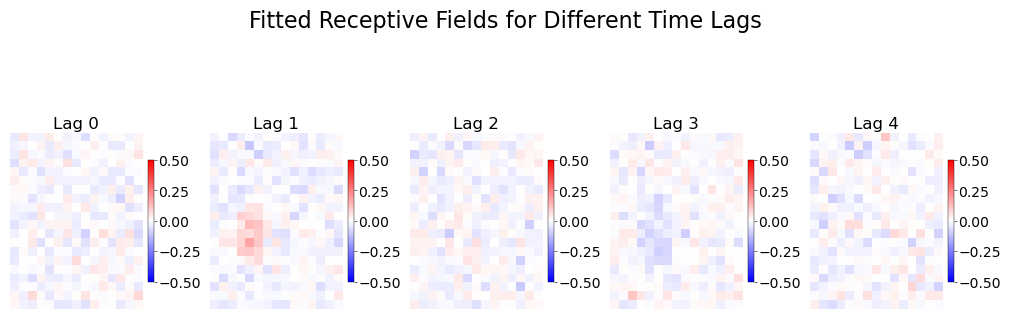

In [ ]:
# --------------------------------------------
# Plot all 5 frames of the fitted RFs (1 pt)
# --------------------------------------------
fig, ax = plt.subplot_mosaic(mosaic=[delta], figsize=(10, 4), constrained_layout=True)
for i, lag in enumerate(delta):
    ax[lag].imshow(w_hat[:, i].reshape((20, 15)), cmap="bwr", vmin=-0.5, vmax=0.5)
    ax[lag].set_title(f"Lag {lag}")
    ax[lag].axis("off")  # Hide axes for better visualization
    # Add colorbar to each subplot
    fig.colorbar(
        ax[lag].images[0], ax=ax[lag], orientation="vertical", fraction=0.046, pad=0.04
    )

plt.suptitle("Fitted Receptive Fields for Different Time Lags", fontsize=16)
plt.savefig("../images/fitted_rf_lags.png")
plt.show()

_Explanation (1 pt)_
...

# Task 3: Separate space/time components

The receptive field of the neuron can be decomposed into a spatial and a temporal component. Because of the way we computed them, both are independent and the resulting spatio-temporal component is thus called separable. As discussed in the lecture, you can use singular-value decomposition to separate these two: 

$$
W = u_1 s_1 v_1^T
$$

Here $u_1$ and $v_1$ are the singular vectors belonging to the 1st singular value $s_1$ and provide a long rank approximation of W, the array with all receptive fields. It is important that the mean is subtracted before computing the SVD.  

Plot the first temporal component and the first spatial component. You can use a Python implementation of SVD. The results can look a bit puzzling, because the sign of the components is arbitrary.

*Grading: 1.5 pts*

In [ ]:
# --------------------------------------------
# Apply SVD to the fitted receptive field,
# you can use either numpy or sklearn (0.5 pt)
# --------------------------------------------
def rank_one_approximation(W: np.ndarray) -> tuple:
    """
    Perform SVD on the mean-subtracted receptive field matrix W.

    Args:
        W (np.ndarray): The receptive field matrix (num_pixels, num_lags).

    Returns:
        tuple: U, s_values, Vt from the SVD decomposition.
    """
    # Mean subtract the receptive field matrix
    W_mean_subtracted = W - np.mean(W, axis=0)

    # Perform SVD
    U, s_values, Vt = np.linalg.svd(W_mean_subtracted, full_matrices=False)

    # Extract first spatial component u_1
    u_1 = U[:, 0]
    # Extract first temporal component v_1
    v_1 = Vt[0, :]
    # Extract first singular value s_1
    s_1 = s_values[0]

    return u_1, s_1, v_1


u_1, s_1, v_1 = rank_one_approximation(w_hat)
w_approx = u_1[:, np.newaxis] * s_1 * v_1[np.newaxis, :]

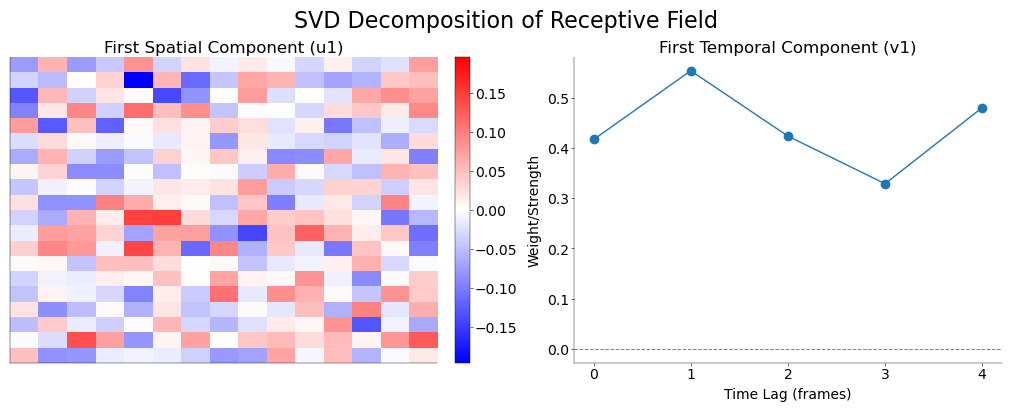

In [ ]:
# -------------------------------------------------
# Plot the spatial and temporal components (1 pt)
# -------------------------------------------------

fig, ax = plt.subplot_mosaic(
    mosaic=[["Spatial", "Temporal"]], figsize=(10, 4), constrained_layout=True
)
# add plot
Dx_real = 20
Dy_real = 15
spatial_component_2D = u_1.reshape((Dx_real, Dy_real))
max_abs_val_spatial = np.max(np.abs(spatial_component_2D))
im_spatial = ax["Spatial"].imshow(
    spatial_component_2D,
    cmap="bwr",  # Blue-white-red is good for RFs
    vmin=-max_abs_val_spatial,
    vmax=max_abs_val_spatial,
    aspect="auto",
)  # Adjust aspect as needed

ax["Spatial"].set_title("First Spatial Component (u1)")
ax["Spatial"].set_xticks([])  # Optional: remove ticks
ax["Spatial"].set_yticks([])  # Optional: remove ticks
fig.colorbar(
    im_spatial, ax=ax["Spatial"], orientation="vertical", fraction=0.046, pad=0.04
)

time_lags_for_plot = np.arange(len(delta))  # Should be [0, 1, 2, 3, 4]

ax["Temporal"].plot(time_lags_for_plot, v_1, marker="o", linestyle="-")
ax["Temporal"].set_title("First Temporal Component (v1)")
ax["Temporal"].set_xlabel("Time Lag (frames)")
ax["Temporal"].set_ylabel("Weight/Strength")
ax["Temporal"].axhline(
    0, color="grey", linestyle="--", linewidth=0.7
)  # Add a zero line
ax["Temporal"].set_xticks(time_lags_for_plot)  # Ensure all lags are shown as ticks
# Add plot
plt.suptitle("SVD Decomposition of Receptive Field", fontsize=16)
plt.savefig("../images/svd_rf_components.png")
plt.show()

# Task 4: Regularized receptive field

As you can see, maximum likelihood estimation of linear receptive fields can be quite noisy, if little data is available. 

To improve on this, one can regularize the receptive field vector and a term to the cost function


$$
C(w) = L(w) + \alpha ||w||_p^2
$$

Here, the $p$ indicates which norm of $w$ is used: for $p=2$, this is shrinks all coefficient equally to zero; for $p=1$, it favors sparse solutions, a penality also known as lasso. Because the 1-norm is not smooth at zero, it is not as straightforward to implement "by hand". 

Use a toolbox with an implementation of the lasso-penalization and fit the receptive field. Possibly, you will have to try different values of the regularization parameter $\alpha$. Plot your estimates from above and the lasso-estimates. How do they differ? What happens when you increase or decrease $alpha$?

If you want to keep the Poisson noise model, you can use the implementation in [`pyglmnet`](https://pypi.python.org/pypi/pyglmnet). Otherwise, you can also resort to the linear model from `sklearn` which assumes Gaussian noise (which in my hands was much faster).

*Grading: 3 pts*


In [ ]:
from sklearn import linear_model
from pyglmnet import GLM


def fit_lasso_rf(
    full_stimulus_matrix: np.ndarray,  # Original s (num_pixels, num_total_frames)
    full_counts_vector: np.ndarray,  # Original c_binned (num_total_frames,)
    lag: int = 0,
    reg_strength: float = 0.1,  # This is the 'alpha' from your task's formula C(w)=L(w)+alpha*||w||_1
    max_iter: int = 1000,
    tol: float = 1e-4,
    learning_rate: float = 0.01,  # Added learning rate, may need tuning
) -> np.ndarray:
    """
    Fit a Lasso regularized receptive field using pyglmnet for a specific lag.

    Args:
        full_stimulus_matrix (np.ndarray): Stimulus matrix (Dx * Dy, nT).
        full_counts_vector (np.ndarray): Spike counts (nT,).
        lag (int): Time lag to apply.
        reg_strength (float): Regularization strength (lambda in pyglmnet).
        max_iter (int): Maximum number of iterations for optimization.
        tol (float): Tolerance for convergence.
        learning_rate (float): Learning rate for the optimizer.

    Returns:
        np.ndarray: Estimated receptive field (Dx * Dy,), or zeros if fit fails.
    """
    num_pixels = full_stimulus_matrix.shape[0]

    if lag == 0:
        stim_for_lag_samples = full_stimulus_matrix.T
        counts_for_lag = full_counts_vector
    else:
        if lag >= full_stimulus_matrix.shape[1] or lag >= len(full_counts_vector):
            print(f"Lag value {lag} is too large for data length. Returning zeros.")
            return np.zeros(num_pixels)
        # Stimulus at t-lag predicts spikes at t
        stim_for_lag_samples = full_stimulus_matrix[:, :-lag].T
        counts_for_lag = full_counts_vector[lag:]

    if stim_for_lag_samples.shape[0] == 0:
        print(f"Zero samples after lagging for lag {lag}. Returning zeros.")
        return np.zeros(num_pixels)
    if stim_for_lag_samples.shape[0] != len(counts_for_lag):
        print(
            f"Mismatch in samples after lagging for lag {lag}. "
            f"X has {stim_for_lag_samples.shape[0]}, y has {len(counts_for_lag)}. Returning zeros."
        )
        return np.zeros(num_pixels)

    model = GLM(
        distr="poisson",
        alpha=1.0,  # This is L1_ratio, 1.0 for pure Lasso
        reg_lambda=reg_strength,  # Regularization strength
        max_iter=max_iter,
        tol=tol,
        learning_rate=learning_rate,
        verbose=True,
    )

    try:
        print(
            f"Fitting Lasso for lag {lag}, reg_strength {reg_strength} with X shape {stim_for_lag_samples.shape} and y shape {counts_for_lag.shape}"
        )
        model.fit(stim_for_lag_samples, counts_for_lag)
        # NEW logic to access beta_:
        if model.beta_ is not None:
            # For pyglmnet.GLM with a single reg_lambda, beta_ is expected to be 1D (n_features,)
            if model.beta_.ndim == 1:
                print(
                    f"Fit successful for lag {lag}, reg_strength {reg_strength}. Beta shape: {model.beta_.shape}"
                )
                return (
                    model.beta_.flatten()
                )  # .flatten() is mostly for consistency here
            elif model.beta_.ndim == 2 and model.beta_.shape[1] == 1:
                # Some pyglmnet versions/forks might still wrap a single lambda result in a 2D array
                print(
                    f"Fit successful (beta_ is 2D) for lag {lag}, reg_strength {reg_strength}. Beta shape: {model.beta_.shape}"
                )
                return model.beta_[:, 0].flatten()
            else:
                # This case would be unexpected
                print(
                    f"Unexpected beta_ shape from pyglmnet.GLM: {model.beta_.shape} for lag {lag}, reg_strength {reg_strength}"
                )
                return np.zeros(num_pixels)
        else:
            # This case means fit might have run, but beta_ was not set (problematic)
            print(
                f"Fit completed but model.beta_ is None for lag {lag}, reg_strength {reg_strength}."
            )
            return np.zeros(num_pixels)
    except Exception as e:
        print(
            f"Error during pyglmnet fit for lag {lag}, reg_strength {reg_strength}: {e}"
        )
        return np.zeros(num_pixels)

In [ ]:
# ------------------------------------------
# Fit the receptive field with time lags of
# 0 to 4 frames separately (the same as before)
# with sklearn or pyglmnet for different values
# of alpha (1 pt)
# ------------------------------------------

delta = [0, 1, 2, 3, 4]
alphas = np.logspace(-5, -3, 8)
np.float = np.float64  # Ensure numpy uses float64 for consistency
# Initialize for lasso results
w_hat_lasso_for_alpha = np.zeros(
    (s.shape[0], len(delta), len(alphas))
)  # (num_pixels, num_lags, num_alphas)
for alpha in alphas:
    print(f"Fitting Lasso RF for alpha {alpha}...")
    # Initialize the array to store the receptive fields

    for lag in delta:
        print(f"Fitting Lasso RF for lag {lag}...")
        # Fit the Lasso regularized receptive field
        w_lasso = fit_lasso_rf(
            s,
            spike_counts_per_frame,
            lag=lag,
            reg_strength=alpha,
            tol=1e-4,
            max_iter=1000,
            learning_rate=1e-4,
        )
        # Store the result in w_hat for plotting later
        w_hat_lasso_for_alpha[:, lag, np.where(alphas == alpha)[0][0]] = w_lasso

Lambda: 0.0000
INFO:pyglmnet:Lambda: 0.0000


Fitting Lasso RF for alpha 1e-05...
Fitting Lasso RF for lag 0...
Fitting Lasso for lag 0, reg_strength 1e-05 with X shape (1488, 300) and y shape (1488,)


/Users/aakarsh/opt/anaconda3/envs/tue-summer-2025-oasis/lib/python3.11/site-packages/pyglmnet/pyglmnet.py:863: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(
Lambda: 0.0000
INFO:pyglmnet:Lambda: 0.0000


Fit successful for lag 0, reg_strength 1e-05. Beta shape: (300,)
Fitting Lasso RF for lag 1...
Fitting Lasso for lag 1, reg_strength 1e-05 with X shape (1487, 300) and y shape (1487,)


Lambda: 0.0000
INFO:pyglmnet:Lambda: 0.0000


Fit successful for lag 1, reg_strength 1e-05. Beta shape: (300,)
Fitting Lasso RF for lag 2...
Fitting Lasso for lag 2, reg_strength 1e-05 with X shape (1486, 300) and y shape (1486,)


Lambda: 0.0000
INFO:pyglmnet:Lambda: 0.0000


Fit successful for lag 2, reg_strength 1e-05. Beta shape: (300,)
Fitting Lasso RF for lag 3...
Fitting Lasso for lag 3, reg_strength 1e-05 with X shape (1485, 300) and y shape (1485,)


Lambda: 0.0000
INFO:pyglmnet:Lambda: 0.0000


Fit successful for lag 3, reg_strength 1e-05. Beta shape: (300,)
Fitting Lasso RF for lag 4...
Fitting Lasso for lag 4, reg_strength 1e-05 with X shape (1484, 300) and y shape (1484,)


Lambda: 0.0000
INFO:pyglmnet:Lambda: 0.0000


Fit successful for lag 4, reg_strength 1e-05. Beta shape: (300,)
Fitting Lasso RF for alpha 1.9306977288832496e-05...
Fitting Lasso RF for lag 0...
Fitting Lasso for lag 0, reg_strength 1.9306977288832496e-05 with X shape (1488, 300) and y shape (1488,)


Lambda: 0.0000
INFO:pyglmnet:Lambda: 0.0000


Fit successful for lag 0, reg_strength 1.9306977288832496e-05. Beta shape: (300,)
Fitting Lasso RF for lag 1...
Fitting Lasso for lag 1, reg_strength 1.9306977288832496e-05 with X shape (1487, 300) and y shape (1487,)


Lambda: 0.0000
INFO:pyglmnet:Lambda: 0.0000


Fit successful for lag 1, reg_strength 1.9306977288832496e-05. Beta shape: (300,)
Fitting Lasso RF for lag 2...
Fitting Lasso for lag 2, reg_strength 1.9306977288832496e-05 with X shape (1486, 300) and y shape (1486,)


Lambda: 0.0000
INFO:pyglmnet:Lambda: 0.0000


Fit successful for lag 2, reg_strength 1.9306977288832496e-05. Beta shape: (300,)
Fitting Lasso RF for lag 3...
Fitting Lasso for lag 3, reg_strength 1.9306977288832496e-05 with X shape (1485, 300) and y shape (1485,)


Lambda: 0.0000
INFO:pyglmnet:Lambda: 0.0000


Fit successful for lag 3, reg_strength 1.9306977288832496e-05. Beta shape: (300,)
Fitting Lasso RF for lag 4...
Fitting Lasso for lag 4, reg_strength 1.9306977288832496e-05 with X shape (1484, 300) and y shape (1484,)


Lambda: 0.0000
INFO:pyglmnet:Lambda: 0.0000


Fit successful for lag 4, reg_strength 1.9306977288832496e-05. Beta shape: (300,)
Fitting Lasso RF for alpha 3.727593720314938e-05...
Fitting Lasso RF for lag 0...
Fitting Lasso for lag 0, reg_strength 3.727593720314938e-05 with X shape (1488, 300) and y shape (1488,)


Lambda: 0.0000
INFO:pyglmnet:Lambda: 0.0000


Fit successful for lag 0, reg_strength 3.727593720314938e-05. Beta shape: (300,)
Fitting Lasso RF for lag 1...
Fitting Lasso for lag 1, reg_strength 3.727593720314938e-05 with X shape (1487, 300) and y shape (1487,)


Lambda: 0.0000
INFO:pyglmnet:Lambda: 0.0000


Fit successful for lag 1, reg_strength 3.727593720314938e-05. Beta shape: (300,)
Fitting Lasso RF for lag 2...
Fitting Lasso for lag 2, reg_strength 3.727593720314938e-05 with X shape (1486, 300) and y shape (1486,)


Lambda: 0.0000
INFO:pyglmnet:Lambda: 0.0000


Fit successful for lag 2, reg_strength 3.727593720314938e-05. Beta shape: (300,)
Fitting Lasso RF for lag 3...
Fitting Lasso for lag 3, reg_strength 3.727593720314938e-05 with X shape (1485, 300) and y shape (1485,)


Lambda: 0.0000
INFO:pyglmnet:Lambda: 0.0000


Fit successful for lag 3, reg_strength 3.727593720314938e-05. Beta shape: (300,)
Fitting Lasso RF for lag 4...
Fitting Lasso for lag 4, reg_strength 3.727593720314938e-05 with X shape (1484, 300) and y shape (1484,)


Lambda: 0.0001
INFO:pyglmnet:Lambda: 0.0001


Fit successful for lag 4, reg_strength 3.727593720314938e-05. Beta shape: (300,)
Fitting Lasso RF for alpha 7.196856730011514e-05...
Fitting Lasso RF for lag 0...
Fitting Lasso for lag 0, reg_strength 7.196856730011514e-05 with X shape (1488, 300) and y shape (1488,)


Lambda: 0.0001
INFO:pyglmnet:Lambda: 0.0001


Fit successful for lag 0, reg_strength 7.196856730011514e-05. Beta shape: (300,)
Fitting Lasso RF for lag 1...
Fitting Lasso for lag 1, reg_strength 7.196856730011514e-05 with X shape (1487, 300) and y shape (1487,)


Lambda: 0.0001
INFO:pyglmnet:Lambda: 0.0001


Fit successful for lag 1, reg_strength 7.196856730011514e-05. Beta shape: (300,)
Fitting Lasso RF for lag 2...
Fitting Lasso for lag 2, reg_strength 7.196856730011514e-05 with X shape (1486, 300) and y shape (1486,)


Lambda: 0.0001
INFO:pyglmnet:Lambda: 0.0001


Fit successful for lag 2, reg_strength 7.196856730011514e-05. Beta shape: (300,)
Fitting Lasso RF for lag 3...
Fitting Lasso for lag 3, reg_strength 7.196856730011514e-05 with X shape (1485, 300) and y shape (1485,)


Lambda: 0.0001
INFO:pyglmnet:Lambda: 0.0001


Fit successful for lag 3, reg_strength 7.196856730011514e-05. Beta shape: (300,)
Fitting Lasso RF for lag 4...
Fitting Lasso for lag 4, reg_strength 7.196856730011514e-05 with X shape (1484, 300) and y shape (1484,)


Lambda: 0.0001
INFO:pyglmnet:Lambda: 0.0001


Fit successful for lag 4, reg_strength 7.196856730011514e-05. Beta shape: (300,)
Fitting Lasso RF for alpha 0.00013894954943731373...
Fitting Lasso RF for lag 0...
Fitting Lasso for lag 0, reg_strength 0.00013894954943731373 with X shape (1488, 300) and y shape (1488,)


Lambda: 0.0001
INFO:pyglmnet:Lambda: 0.0001


Fit successful for lag 0, reg_strength 0.00013894954943731373. Beta shape: (300,)
Fitting Lasso RF for lag 1...
Fitting Lasso for lag 1, reg_strength 0.00013894954943731373 with X shape (1487, 300) and y shape (1487,)


Lambda: 0.0001
INFO:pyglmnet:Lambda: 0.0001


Fit successful for lag 1, reg_strength 0.00013894954943731373. Beta shape: (300,)
Fitting Lasso RF for lag 2...
Fitting Lasso for lag 2, reg_strength 0.00013894954943731373 with X shape (1486, 300) and y shape (1486,)


Lambda: 0.0001
INFO:pyglmnet:Lambda: 0.0001


Fit successful for lag 2, reg_strength 0.00013894954943731373. Beta shape: (300,)
Fitting Lasso RF for lag 3...
Fitting Lasso for lag 3, reg_strength 0.00013894954943731373 with X shape (1485, 300) and y shape (1485,)


Lambda: 0.0001
INFO:pyglmnet:Lambda: 0.0001


Fit successful for lag 3, reg_strength 0.00013894954943731373. Beta shape: (300,)
Fitting Lasso RF for lag 4...
Fitting Lasso for lag 4, reg_strength 0.00013894954943731373 with X shape (1484, 300) and y shape (1484,)


Lambda: 0.0003
INFO:pyglmnet:Lambda: 0.0003


Fit successful for lag 4, reg_strength 0.00013894954943731373. Beta shape: (300,)
Fitting Lasso RF for alpha 0.00026826957952797245...
Fitting Lasso RF for lag 0...
Fitting Lasso for lag 0, reg_strength 0.00026826957952797245 with X shape (1488, 300) and y shape (1488,)


Lambda: 0.0003
INFO:pyglmnet:Lambda: 0.0003


Fit successful for lag 0, reg_strength 0.00026826957952797245. Beta shape: (300,)
Fitting Lasso RF for lag 1...
Fitting Lasso for lag 1, reg_strength 0.00026826957952797245 with X shape (1487, 300) and y shape (1487,)


Lambda: 0.0003
INFO:pyglmnet:Lambda: 0.0003


Fit successful for lag 1, reg_strength 0.00026826957952797245. Beta shape: (300,)
Fitting Lasso RF for lag 2...
Fitting Lasso for lag 2, reg_strength 0.00026826957952797245 with X shape (1486, 300) and y shape (1486,)


Lambda: 0.0003
INFO:pyglmnet:Lambda: 0.0003


Fit successful for lag 2, reg_strength 0.00026826957952797245. Beta shape: (300,)
Fitting Lasso RF for lag 3...
Fitting Lasso for lag 3, reg_strength 0.00026826957952797245 with X shape (1485, 300) and y shape (1485,)


Lambda: 0.0003
INFO:pyglmnet:Lambda: 0.0003


Fit successful for lag 3, reg_strength 0.00026826957952797245. Beta shape: (300,)
Fitting Lasso RF for lag 4...
Fitting Lasso for lag 4, reg_strength 0.00026826957952797245 with X shape (1484, 300) and y shape (1484,)


Lambda: 0.0005
INFO:pyglmnet:Lambda: 0.0005


Fit successful for lag 4, reg_strength 0.00026826957952797245. Beta shape: (300,)
Fitting Lasso RF for alpha 0.0005179474679231213...
Fitting Lasso RF for lag 0...
Fitting Lasso for lag 0, reg_strength 0.0005179474679231213 with X shape (1488, 300) and y shape (1488,)


Lambda: 0.0005
INFO:pyglmnet:Lambda: 0.0005


Fit successful for lag 0, reg_strength 0.0005179474679231213. Beta shape: (300,)
Fitting Lasso RF for lag 1...
Fitting Lasso for lag 1, reg_strength 0.0005179474679231213 with X shape (1487, 300) and y shape (1487,)


Lambda: 0.0005
INFO:pyglmnet:Lambda: 0.0005


Fit successful for lag 1, reg_strength 0.0005179474679231213. Beta shape: (300,)
Fitting Lasso RF for lag 2...
Fitting Lasso for lag 2, reg_strength 0.0005179474679231213 with X shape (1486, 300) and y shape (1486,)


Lambda: 0.0005
INFO:pyglmnet:Lambda: 0.0005


Fit successful for lag 2, reg_strength 0.0005179474679231213. Beta shape: (300,)
Fitting Lasso RF for lag 3...
Fitting Lasso for lag 3, reg_strength 0.0005179474679231213 with X shape (1485, 300) and y shape (1485,)


Lambda: 0.0005
INFO:pyglmnet:Lambda: 0.0005


Fit successful for lag 3, reg_strength 0.0005179474679231213. Beta shape: (300,)
Fitting Lasso RF for lag 4...
Fitting Lasso for lag 4, reg_strength 0.0005179474679231213 with X shape (1484, 300) and y shape (1484,)


Lambda: 0.0010
INFO:pyglmnet:Lambda: 0.0010


Fit successful for lag 4, reg_strength 0.0005179474679231213. Beta shape: (300,)
Fitting Lasso RF for alpha 0.001...
Fitting Lasso RF for lag 0...
Fitting Lasso for lag 0, reg_strength 0.001 with X shape (1488, 300) and y shape (1488,)


Lambda: 0.0010
INFO:pyglmnet:Lambda: 0.0010


Fit successful for lag 0, reg_strength 0.001. Beta shape: (300,)
Fitting Lasso RF for lag 1...
Fitting Lasso for lag 1, reg_strength 0.001 with X shape (1487, 300) and y shape (1487,)


Lambda: 0.0010
INFO:pyglmnet:Lambda: 0.0010


Fit successful for lag 1, reg_strength 0.001. Beta shape: (300,)
Fitting Lasso RF for lag 2...
Fitting Lasso for lag 2, reg_strength 0.001 with X shape (1486, 300) and y shape (1486,)


Lambda: 0.0010
INFO:pyglmnet:Lambda: 0.0010


Fit successful for lag 2, reg_strength 0.001. Beta shape: (300,)
Fitting Lasso RF for lag 3...
Fitting Lasso for lag 3, reg_strength 0.001 with X shape (1485, 300) and y shape (1485,)


Lambda: 0.0010
INFO:pyglmnet:Lambda: 0.0010


Fit successful for lag 3, reg_strength 0.001. Beta shape: (300,)
Fitting Lasso RF for lag 4...
Fitting Lasso for lag 4, reg_strength 0.001 with X shape (1484, 300) and y shape (1484,)
Fit successful for lag 4, reg_strength 0.001. Beta shape: (300,)


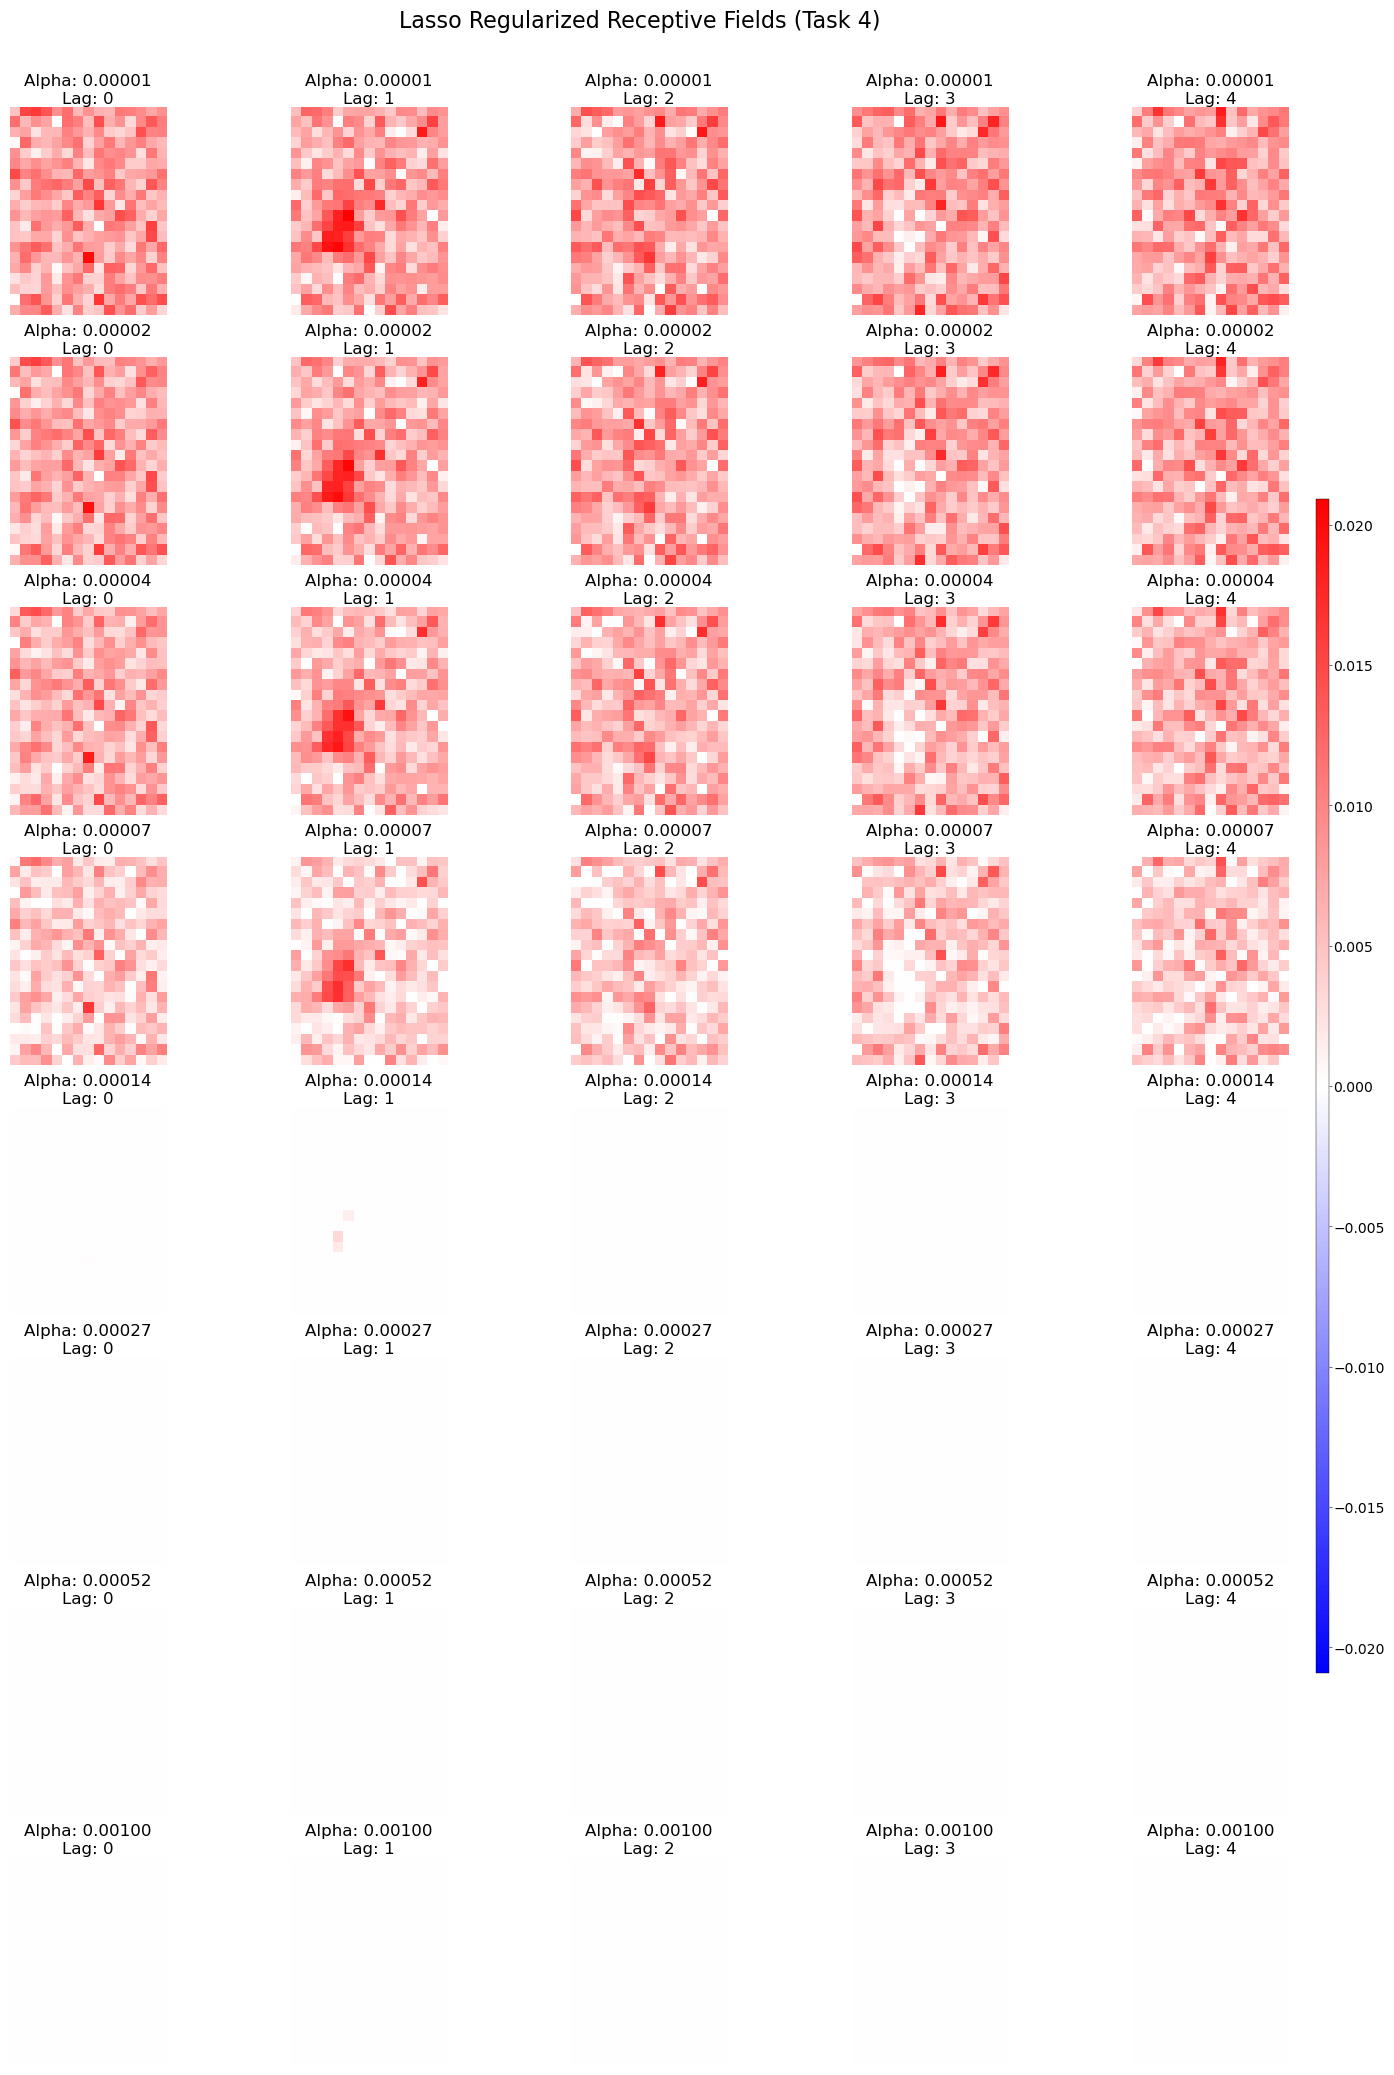

In [34]:
# ------------------------------------------
# plot the estimated receptive fields (1 pt)
# ------------------------------------------

# %%
# 1. Determine global symmetric color limits
if w_hat_lasso_for_alpha.size > 0:  # Ensure there's data
    global_max_abs_val = np.max(np.abs(w_hat_lasso_for_alpha))
    global_vmin = -global_max_abs_val
    global_vmax = global_max_abs_val
else:
    print("Warning: w_hat_lasso_all_results is empty. Setting default color limits.")
    global_vmin = -0.5
    global_vmax = 0.5
    print("Using vmin:", global_vmin, "and vmax:", global_vmax)


fig, ax = plt.subplots(
    len(alphas),
    len(delta),
    figsize=(
        max(10, 3 * len(delta)),
        max(4, 2.5 * len(alphas)),
    ),  # Adjust figsize dynamically
    constrained_layout=True,
    squeeze=False,  # Ensures ax is always a 2D array
)

# Variable to store one of the image objects for the colorbar
mappable = None

# 3. Loop and plot with shared color limits
for i, alpha_val in enumerate(alphas):  # i is the row index (for alphas)
    for j, lag_val in enumerate(delta):  # j is the column index (for lags)
        # Access the correct RF: pixels, lag_index, alpha_index
        # Assuming w_hat_lasso_all_results is (num_pixels, num_lags, num_alphas)
        rf_data_flat = w_hat_lasso_for_alpha[:, j, i]
        rf_image = rf_data_flat.reshape((Dx_real, Dy_real))

        im = ax[i, j].imshow(
            rf_image,
            cmap="bwr",
            vmin=global_vmin,  # Use global vmin
            vmax=global_vmax,  # Use global vmax
        )
        mappable = im  # Store the last (or any) mappable object

        ax[i, j].set_title(f"Alpha: {alpha_val:.5f}\nLag: {lag_val}")
        ax[i, j].axis("off")  # Hide axes for better visualization

# 4. Add a single colorbar for the entire figure
if mappable is not None:
    fig.colorbar(
        mappable,
        ax=ax.ravel().tolist(),
        shrink=0.6,
        aspect=20 * len(alphas) * 0.6,
        pad=0.02,
    )
else:
    print("No images were plotted, so no colorbar will be added.")

plt.suptitle(
    f"Lasso Regularized Receptive Fields (Task 4)",
    fontsize=16,
    y=1.03 if len(alphas) > 1 else 1.0,
)  # Adjust y for suptitle
plt.savefig("../images/lasso_rfs_shared_cbar.png")
plt.show()

_Explanation (1 pt)_
...

## Bonus Task (Optional): Spike Triggered Average

Instead of the Maximum Likelihood implementation above, estimate the receptive field using the spike triggered average.
Use it to increase the temporal resolution of your receptive field estimate.
Perform the SVD analysis for your STA-based receptive field and plot the spatial and temporal kernel as in Task 3.

**Questions:**
1. Explain how / why you chose a specific time delta.
2. Reconsider what you know about STA. Is it suitable to use STA for this data? Why/why not? What are the (dis-)advantages of using the MLE based method from above?

_Grading: 1 BONUS Point._


_BONUS Points do not count for this individual coding lab, but sum up to 5% of your **overall coding lab grade**. There are 4 BONUS points across all coding labs._